<a href="https://colab.research.google.com/github/randoago/ELM_Papsmear/blob/main/ELM_GLCM_Papsmear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
from scipy.linalg import pinv2, inv #for ELM
import time


from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import entropy
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

#============================= **Real Data** =============================

Pembagian Dataset (60:40) :


> Train dataset:
*   Adenocarcinoma : 30
*   HSIL : 298
*   SCC : 29

> Test dataset:
*   Adenocarcinoma : 22
*   HSIL : 194
*   SCC : 23




# GLCM

##================ **GLCM Train** ===================



In [ ]:
data=[]
labels=[]
random.seed(42)
entr =[]
dir = '/content/drive/MyDrive/data_new/3class_60_40/train/'
imagePaths = sorted(list(os.listdir(dir)))
random.shuffle(imagePaths)
print(imagePaths)

for img in imagePaths:

    path=sorted(list(os.listdir(dir+img)))
    #print(path)

    for i in path:
    
      image = cv2.imread(dir+img+'/'+i)
      #print(image)
      image = cv2.resize(image, (512,512))
      gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
      h, w = gray.shape
      ymin, ymax, xmin, xmax = h//3, h*2//3, w//3, w*2//3
      crop = gray[ymin:ymax, xmin:xmax]
         
      resize = cv2.resize(crop, (0,0), fx=0.5, fy=0.5)
      ent = entropy (resize)
      entr.append(ent)
            
      data.append(resize)

      l = label = img

      
      labels.append(l)

['HSIL', 'Adenocarcinoma', 'SquamousCellCarcinoma']


In [ ]:
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics.cluster import entropy

# ----------------- calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135 ----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    
    glcm = greycomatrix(img, 
                        distances=dists, 
                        angles=agls, 
                        levels=lvl,
                        symmetric=sym, 
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in greycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label) 
    
    return feature


# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['contrast', 'correlation', 'homogeneity', 'energy']

glcm_all_agls = []
for img, label in zip(data, labels): 
    glcm_all_agls.append(
            calc_glcm_all_agls(img, 
                                label, 
                                props=properties)
                            )
 
columns = []
angles = ['0', '45', '90','135']
for name in properties :
    for ang in angles:
        columns.append(name + "_" + ang)
        
columns.append("label")

In [ ]:
import pandas as pd 

# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls, 
                      columns = columns)


In [ ]:
glcm_df

,contrast_0,contrast_45,contrast_90,contrast_135,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,homogeneity_90,homogeneity_135,energy_0,energy_45,energy_90,energy_135,label
0,580.475883,873.868382,815.220356,867.007882,0.932769,0.897329,0.903480,0.897776,0.112373,0.079750,0.076062,0.074653,0.019019,0.017124,0.016592,0.016923,HSIL
1,949.253661,1000.891880,800.325151,1049.330161,0.757385,0.744192,0.797818,0.732004,0.134885,0.125873,0.140946,0.134849,0.046222,0.040711,0.044914,0.044697,HSIL
2,946.330462,1276.026770,999.146425,927.341612,0.853925,0.794233,0.839198,0.850649,0.077277,0.076657,0.082384,0.074915,0.018977,0.017145,0.018277,0.017296,HSIL
3,999.020098,926.708507,945.580103,1275.953748,0.839233,0.850770,0.854098,0.794271,0.082494,0.075022,0.077252,0.076287,0.018038,0.017262,0.018915,0.016974,HSIL
4,945.090439,1274.726353,998.829601,926.726056,0.854166,0.794457,0.839231,0.850764,0.077696,0.076422,0.082219,0.074952,0.018791,0.017022,0.018214,0.017219,HSIL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,2979.518662,3250.041344,2641.481481,3128.195419,0.522462,0.468360,0.578882,0.486578,0.037078,0.037555,0.045620,0.038107,0.011638,0.011732,0.012079,0.011777,SquamousCellCarcinoma
353,3806.005742,3748.521416,3013.545220,3665.443040,0.208192,0.214055,0.369026,0.234306,0.239714,0.236142,0.266322,0.240092,0.175679,0.178114,0.194478,0.178068,SquamousCellCarcinoma
354,5086.191645,5078.376115,4189.065604,5220.514575,0.564751,0.565282,0.638179,0.552167,0.052508,0.047526,0.063392,0.055703,0.019094,0.017245,0.021340,0.021045,SquamousCellCarcinoma
355,7344.964255,7170.697799,5364.485070,7476.991820,0.172071,0.184662,0.388908,0.148669,0.024841,0.028531,0.035063,0.027503,0.010897,0.011208,0.011898,0.011091,SquamousCellCarcinoma


In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(glcm_df.label)
glcm_df['label'] = le.transform(glcm_df.label)


In [ ]:
contrast = glcm_df[['contrast_0','contrast_45','contrast_90','contrast_135']].mean(axis=1)
contrast

0       784.143126
1       949.950213
2      1037.211317
3      1036.815614
4      1036.343112
          ...     
352    2999.809227
353    3558.378854
354    4893.536985
355    6839.284736
356    4243.392407
Length: 357, dtype: float64

In [ ]:
correlation = glcm_df[['correlation_0','correlation_45','correlation_90','correlation_135']].mean(axis=1)
correlation

0      0.907839
1      0.757850
2      0.834501
3      0.834593
4      0.834655
         ...   
352    0.514071
353    0.256395
354    0.580095
355    0.223577
356    0.588566
Length: 357, dtype: float64

In [ ]:
homogeneity = glcm_df[['homogeneity_0','homogeneity_45','homogeneity_90','homogeneity_135']].mean(axis=1)
homogeneity

0      0.085710
1      0.134138
2      0.077808
3      0.077764
4      0.077822
         ...   
352    0.039590
353    0.245567
354    0.054782
355    0.028984
356    0.043871
Length: 357, dtype: float64

In [ ]:
energy = glcm_df[['energy_0','energy_45','energy_90','energy_135']].mean(axis=1)
energy

0      0.017415
1      0.044136
2      0.017924
3      0.017797
4      0.017811
         ...   
352    0.011807
353    0.181585
354    0.019681
355    0.011274
356    0.013047
Length: 357, dtype: float64

In [ ]:
train = pd.DataFrame({"contrast" : contrast , "correlation" : correlation, "homogeneity" : homogeneity, "energy" : energy, "entropy" : entr, "label" : glcm_df['label']})
train

,contrast,correlation,homogeneity,energy,entropy,label
0,784.143126,0.907839,0.085710,0.017415,5.156508,1
1,949.950213,0.757850,0.134138,0.044136,4.602605,1
2,1037.211317,0.834501,0.077808,0.017924,5.252736,1
3,1036.815614,0.834593,0.077764,0.017797,5.252232,1
4,1036.343112,0.834655,0.077822,0.017811,5.251450,1
...,...,...,...,...,...,...
352,2999.809227,0.514071,0.039590,0.011807,5.157535,2
353,3558.378854,0.256395,0.245567,0.181585,3.883750,2
354,4893.536985,0.580095,0.054782,0.019681,5.252862,2
355,6839.284736,0.223577,0.028984,0.011274,5.250656,2


In [ ]:
train.label.describe()

count    357.000000
mean       0.997199
std        0.407090
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: label, dtype: float64

In [ ]:
train.groupby("label")["label"].count()

label
0     30
1    298
2     29
Name: label, dtype: int64

##============== **GLCM Test** ==============================

In [ ]:
data=[]
labels=[]
random.seed(42)
entr =[]
dir = '/content/drive/MyDrive/data_new/3class_60_40/test/'
imagePaths = sorted(list(os.listdir(dir)))
random.shuffle(imagePaths)
print(imagePaths)

for img in imagePaths:

    path=sorted(list(os.listdir(dir+img)))
    #print(path)

    for i in path:
    
      image = cv2.imread(dir+img+'/'+i)
      #print(image)
      image = cv2.resize(image, (512,512))
      gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
      h, w = gray.shape
      ymin, ymax, xmin, xmax = h//3, h*2//3, w//3, w*2//3
      crop = gray[ymin:ymax, xmin:xmax]
         
      resize = cv2.resize(crop, (0,0), fx=0.5, fy=0.5)
      ent = entropy (resize)
      entr.append(ent)
            
      data.append(resize)

      l = label = img

      
      labels.append(l)

['HSIL', 'Adenocarcinoma', 'SquamousCellCarcinoma']


In [ ]:
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics.cluster import entropy

# ----------------- calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135 ----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    
    glcm = greycomatrix(img, 
                        distances=dists, 
                        angles=agls, 
                        levels=lvl,
                        symmetric=sym, 
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in greycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    feature.append(label) 
    
    return feature


# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['contrast', 'correlation', 'homogeneity', 'energy']

glcm_all_agls = []
for img, label in zip(data, labels): 
    glcm_all_agls.append(
            calc_glcm_all_agls(img, 
                                label, 
                                props=properties)
                            )
 
columns = []
angles = ['0', '45', '90','135']
for name in properties :
    for ang in angles:
        columns.append(name + "_" + ang)
        
columns.append("label")

In [ ]:
import pandas as pd 

# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls, 
                      columns = columns)


In [ ]:
glcm_df

,contrast_0,contrast_45,contrast_90,contrast_135,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,homogeneity_90,homogeneity_135,energy_0,energy_45,energy_90,energy_135,label
0,572.994258,863.112284,804.300459,859.024539,0.933713,0.898692,0.904880,0.898803,0.112109,0.079164,0.075487,0.077028,0.020261,0.017688,0.017357,0.017923,HSIL
1,998.806058,1274.657942,945.004594,926.516211,0.839203,0.794432,0.854158,0.850772,0.082154,0.076072,0.077243,0.075121,0.018058,0.016971,0.018899,0.017245,HSIL
2,945.625754,926.847264,999.013063,1275.991225,0.854111,0.850772,0.839263,0.794299,0.077797,0.074928,0.082525,0.076645,0.018811,0.017238,0.018197,0.017024,HSIL
3,945.846827,927.230518,998.939707,1274.758328,0.853972,0.850640,0.839170,0.794391,0.077289,0.074940,0.082092,0.076450,0.018958,0.017278,0.018292,0.017142,HSIL
4,1289.047804,1484.378198,1188.529716,1479.006395,0.752402,0.717905,0.778259,0.718764,0.110497,0.100093,0.111840,0.105972,0.027969,0.025948,0.028137,0.029363,HSIL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,3913.719925,3808.638013,3342.885013,3612.996579,0.108374,0.137122,0.243129,0.178033,0.048126,0.048310,0.056934,0.053771,0.016595,0.016642,0.017743,0.017329,SquamousCellCarcinoma
235,2895.714470,2922.610351,2337.605800,2935.847561,0.220049,0.229751,0.373128,0.226620,0.073046,0.074349,0.086467,0.075244,0.022102,0.022264,0.023989,0.022238,SquamousCellCarcinoma
236,3729.192363,3794.007436,3702.704421,4058.100387,0.440571,0.433626,0.440342,0.394260,0.042662,0.037624,0.035137,0.031307,0.012131,0.011892,0.011876,0.011792,SquamousCellCarcinoma
237,2969.375395,2994.046401,2587.456216,3122.582540,0.419442,0.418282,0.493341,0.393106,0.042882,0.042720,0.043587,0.039368,0.013274,0.013544,0.013702,0.013222,SquamousCellCarcinoma


In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(glcm_df.label)
glcm_df['label'] = le.transform(glcm_df.label)


In [ ]:
contrast = glcm_df[['contrast_0','contrast_45','contrast_90','contrast_135']].mean(axis=1)
contrast

0       774.857885
1      1036.246201
2      1036.869327
3      1036.693845
4      1360.240528
          ...     
234    3669.559883
235    2772.944545
236    3821.001152
237    2918.365138
238    3290.887942
Length: 239, dtype: float64

In [ ]:
correlation = glcm_df[['correlation_0','correlation_45','correlation_90','correlation_135']].mean(axis=1)
correlation

0      0.909022
1      0.834641
2      0.834611
3      0.834543
4      0.741833
         ...   
234    0.166665
235    0.262387
236    0.427200
237    0.431043
238    0.257840
Length: 239, dtype: float64

In [ ]:
homogeneity = glcm_df[['homogeneity_0','homogeneity_45','homogeneity_90','homogeneity_135']].mean(axis=1)
homogeneity

0      0.085947
1      0.077648
2      0.077974
3      0.077692
4      0.107100
         ...   
234    0.051785
235    0.077276
236    0.036682
237    0.042139
238    0.037600
Length: 239, dtype: float64

In [ ]:
energy = glcm_df[['energy_0','energy_45','energy_90','energy_135']].mean(axis=1)
energy

0      0.018307
1      0.017793
2      0.017818
3      0.017917
4      0.027854
         ...   
234    0.017077
235    0.022648
236    0.011922
237    0.013435
238    0.013748
Length: 239, dtype: float64

In [ ]:
test = pd.DataFrame({"contrast" : contrast , "correlation" : correlation, "homogeneity" : homogeneity, "energy" : energy, "entropy" : entr, "label" : glcm_df['label']})
test

,contrast,correlation,homogeneity,energy,entropy,label
0,774.857885,0.909022,0.085947,0.018307,5.147212,1
1,1036.246201,0.834641,0.077648,0.017793,5.251024,1
2,1036.869327,0.834611,0.077974,0.017818,5.252612,1
3,1036.693845,0.834543,0.077692,0.017917,5.251720,1
4,1360.240528,0.741833,0.107100,0.027854,4.800459,1
...,...,...,...,...,...,...
234,3669.559883,0.166665,0.051785,0.017077,4.675695,2
235,2772.944545,0.262387,0.077276,0.022648,4.450462,2
236,3821.001152,0.427200,0.036682,0.011922,5.081075,2
237,2918.365138,0.431043,0.042139,0.013435,4.927196,2


In [ ]:
test.label.describe()

count    239.000000
mean       1.004184
std        0.434808
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: label, dtype: float64

In [ ]:
test.groupby("label")["label"].count()

label
0     22
1    194
2     23
Name: label, dtype: int64

##Preparation Data

In [ ]:
x_train = train.drop(['label'], axis='columns')
y_train = train.label
x_test = test.drop(['label'], axis='columns')
y_test = test.label

In [ ]:
y_test[y_test==0]

194    0
195    0
196    0
197    0
198    0
199    0
200    0
201    0
202    0
203    0
204    0
205    0
206    0
207    0
208    0
209    0
210    0
211    0
212    0
213    0
214    0
215    0
Name: label, dtype: int64

In [ ]:
x_train=x_train.to_numpy()
x_test=x_test.to_numpy() 
y_train = y_train.to_numpy() 
y_test = y_test.to_numpy()

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x_train)
x_train = scaler.transform(x_train)

In [ ]:
scaler.fit(x_test)
x_test = scaler.transform(x_test)

In [ ]:
y_train = y_train.ravel() 
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(y_train)

In [ ]:
y_test = y_test.ravel() 
lb = preprocessing.LabelBinarizer()
y_test = lb.fit_transform(y_test)

In [ ]:
y_test

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

#ELM

In [ ]:
input_size = x_train.shape[1]

In [ ]:
input_size

5

In [ ]:
hidden_size = 55

In [ ]:
input_weights = np.random.normal(size=[input_size,hidden_size])
biases = np.random.normal(size=[hidden_size])

In [ ]:
def relu(x):
   return np.maximum(x, 0, x)

In [ ]:
def hidden_nodes(X):
    G = np.dot(X, input_weights)
    G = G + biases
    H = relu(G)
    return H

In [ ]:
output_weights = np.dot(pinv2(hidden_nodes(x_train)), y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
  """Entry point for launching an IPython kernel.


In [ ]:
def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights)
    return out

In [ ]:
prediction = predict(x_test)
correct = 0
total = x_test.shape[0]
acc = []
pred = []
act = []
for i in range(total):
    predicted = np.argmax(prediction[i])
    actual = np.argmax(y_test[i])
    correct += 1 if predicted == actual else 0
    accuracy = correct/total
    acc.append(accuracy)
    act.append(actual)
    pred.append(predicted)


print('Accuracy for ', hidden_size, ' hidden nodes: ', accuracy)

Accuracy for  55  hidden nodes:  0.8744769874476988


In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(act, pred)
confusion_matrix

array([[  4,  11,   7],
       [  6, 183,   5],
       [  0,   1,  22]])

In [ ]:
target_names = ['Adenocarcinoma','HSIL','SCC']

In [ ]:
print(classification_report(act, pred, target_names=target_names))

                precision    recall  f1-score   support

Adenocarcinoma       0.40      0.18      0.25        22
          HSIL       0.94      0.94      0.94       194
           SCC       0.65      0.96      0.77        23

      accuracy                           0.87       239
     macro avg       0.66      0.69      0.65       239
  weighted avg       0.86      0.87      0.86       239



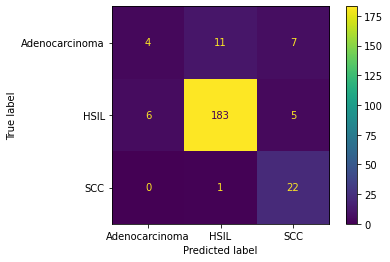

In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = target_names)

cm_display.plot()
plt.show() 

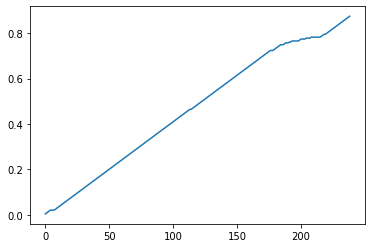

In [ ]:
from matplotlib import pyplot as plt
plt.plot(acc)


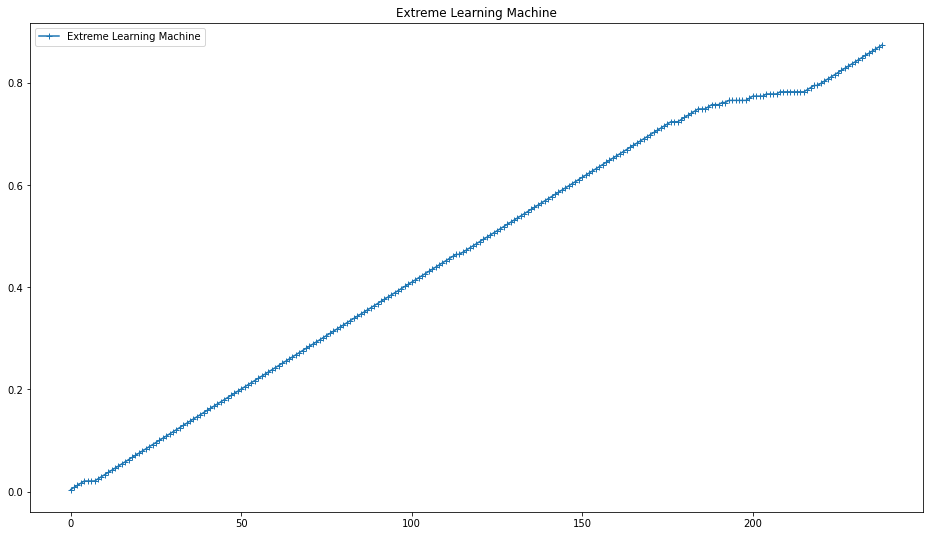

In [ ]:
plt.figure(figsize=(16, 9))
plt.title("Extreme Learning Machine")
plt.plot(acc, '+-', label='Extreme Learning Machine')
plt.legend()